# 0.データ読み込み

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib


In [2]:
gpd_data = gpd.read_file('/workspaces/akita_daizu/data/474+120圃場.geojson')
soil_data = pd.read_excel('/workspaces/akita_daizu/data/0124修正_土壌データ+収量.xlsx', header=0)

UniquIDがふってある120圃場の解析だけで良いので、読み込んだ2ファイルを120圃場ののIDをKeyに接続する

In [3]:
# gpdの結合用うの行の削除と作成
gpd_data['作付け開始年'] = ''
gpd_data['圃場番号'] = gpd_data['uniqueID']
gpd_data['排水性の良否'] = gpd_data['pred_labels']
gpd_data['EVI20902mean'] = gpd_data['EVI2mean']

# gpdの必要な行だけ抽出して結合する ほしい行は以下の4行
selected_gpd = gpd_data[['圃場番号','排水性の良否','作付年_y', 'H23以前_y','播種月日','作付け開始年','EVI20902mean','EVI20903mean','geometry']]


In [4]:
#　この作付け年とH23以前を一つの列に。　まず作付け年が空ならH23以前を入れ込むようにFor
for index, row in selected_gpd[['作付年_y', 'H23以前_y','作付け開始年']].iterrows():
    if row['H23以前_y'] is not None :
        selected_gpd['作付け開始年'][index] =row['H23以前_y']
    elif  row['作付年_y'] is not None :
        selected_gpd['作付け開始年'][index] = row['作付年_y']

# それぞれの和暦を西暦に変更
# H23 2011 H24 2012 H25 2013 R1 2019
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ3～',r'2021',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ2～',r'2020',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ1～',r'2019',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ30～',r'2017',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ28～',r'2016',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ27～',r'2015',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ26～',r'2014',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ25～',r'2013',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ24～',r'2012',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'☑',r'2011',)
selected_gpd['作付け開始年'].unique()

target_selected_gpd = selected_gpd
#まず　GPDとSOILデータでuniqueIDをキーにして全部結合する
merged_pd = pd.merge(soil_data, target_selected_gpd, on=['圃場番号'], how='inner')
# 解析に不要な行の削除 土壌硬度周り
drop_columns = merged_pd.filter(like='土壌硬度', axis=1).columns.values
droped_soil_data = merged_pd.drop(drop_columns, axis = 1)
# 解析に不要な行の削除
drop_columns = ['播種月日_x','生育状況','最大圧の深さの平均', '最大圧力の平均','調査日', '作付年_y', 'H23以前_y','現物重量ｋｇ', '計量時水分％', '圃場面積', '住所', '反収現物重量kg/10a',
       '15%時の重量']
second_droped_soil_data = droped_soil_data.drop(drop_columns, axis = 1)

/tmp/ipykernel_89262/683819552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] =row['H23以前_y']
/tmp/ipykernel_89262/683819552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] = row['作付年_y']
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(Ge

In [5]:
# 作付け開始年はこれでint化　播種日はエクセルで日付けにしといてDateTime化
second_droped_soil_data['作付け開始年'] = second_droped_soil_data['作付け開始年'].map(lambda x: int(x))
second_droped_soil_data['播種月日_y'] = pd.to_datetime(second_droped_soil_data['播種月日_y'])

# DateTimeで評価しようと思ったけど、播種日datatime形式だとheatmap作成時に読み込まれない？ intにする
int_time = second_droped_soil_data['播種月日_y'].map(pd.Timestamp.timestamp).astype(int)
# Formatの調整
int_time = second_droped_soil_data['播種月日_y'].dt.strftime('%m%d')
int2_time = int_time.str.lstrip('0').astype(int)
second_droped_soil_data['播種月日'] = int2_time
# フォーマット直した播種日入力したから古いの削除
second_droped_soil_data = second_droped_soil_data.drop(['播種月日_y'], axis = 1)

In [6]:
# これで収量が入っている行には必ず作付け開始年も入力される = 終了の列以外にnullは存在しない
print(second_droped_soil_data.isnull().sum())

圃場番号                    0
現場測定_EC(㎳／㎝)            0
現場測定_PH                 0
SoilName                0
15%反収現物重量kg/10a        83
実験室測定_EC(㎳／㎝)           0
実験室測定_pH                0
アンモニア態窒素(mgN/100g)      0
硝酸態窒素(mgN/100g)         0
可給隊窒素(mgN/100g)         0
有効態リン酸(mgP2O5/100g)     0
TC(%)                   0
腐食(%)                   0
TN(%)                   0
排水性の良否                  0
作付け開始年                  0
EVI20902mean            0
EVI20903mean            0
geometry                0
播種月日                    0
dtype: int64


In [7]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(second_droped_soil_data["SoilName"].values)

#データ変換
second_droped_soil_data["土壌_CD"] = LE.fit_transform(second_droped_soil_data["SoilName"].values)
print(second_droped_soil_data["土壌_CD"].unique())
print(second_droped_soil_data["SoilName"].unique())

[1 2 0]
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']


In [48]:
# soil_data_wo_error.columns
target_data = second_droped_soil_data[['圃場番号','15%反収現物重量kg/10a','geometry']]

In [49]:
# 画像解析のためgeopandasに戻す
aois = gpd.GeoDataFrame(target_data, geometry='geometry')

In [50]:
# 3mバッファ取った後WGS84に変換
aois['geometry'] = aois.to_crs('epsg:6678').buffer(-3).to_crs('epsg:4326')

In [51]:
# geometry列だけでなくｇｄｆ全体のCRSも変更
aois = aois.to_crs('epsg:4326')
aois.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [52]:
aois

,圃場番号,15%反収現物重量kg/10a,geometry
0,1.0,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
1,2.0,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271..."
2,3.0,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271..."
3,4.0,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271..."
4,5.0,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
...,...,...,...
109,117.0,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287..."
110,118.0,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287..."
111,119.0,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287..."
112,120.0,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287..."


# 1. 衛星画像データの読み込み


## 1-1データの描画確認

In [53]:
import rasterio as rio
tif_path = '/workspaces/akita_daizu/data/raster/2021-06-25.tiff'
tif =  rio.open(tif_path)


<AxesSubplot:>

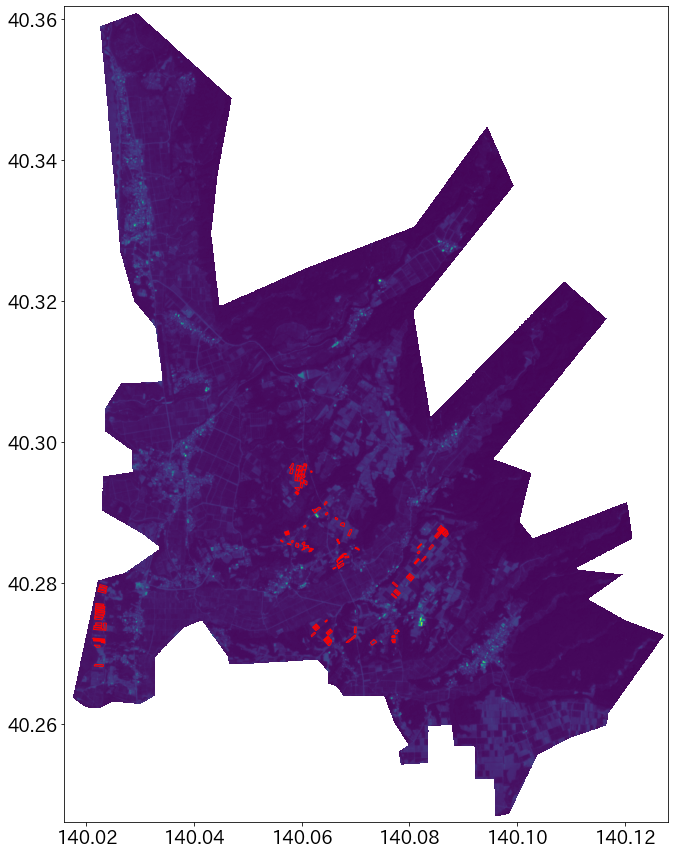

In [54]:

import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
raster = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(raster, ax=ax)
aois.plot(ax=ax, facecolor='none', edgecolor='red')

## 1-2EVI2の作成

In [55]:
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

In [56]:
data_dir = '/workspaces/akita_daizu/data/raster'

In [61]:
import glob
import os
# evi　計算する画像のリスト
scene_directories = glob.glob(os.path.join(data_dir, '*.tiff'))

In [62]:
# ゆはらさんのコードから　のちに整理する
from rasterio.mask import mask
from vegiindex import evi2
def rio_mask(image, geometry):
    try:
        # all_touched=Trueにすることにより、農地ポリゴンが触れているピクセルの値も取得する
        out_image, _ = mask(image, [geometry], crop=True, all_touched=True, filled=False)
    except ValueError:
        #
        return None
    return out_image
def calc_evi2s(geoms, tif_path):
    with rio.open(tif_path) as image:
        mask_geoms = map(lambda geom: rio_mask(image, geom), geoms)
        _indicies = map(lambda mask_image: None if mask_image is None else evi2(
            mask_image[2], mask_image[3]), mask_geoms)
        _indicies_median = list(map(lambda x: 0 if x is None else np.ma.median(np.ma.masked_invalid(x)), _indicies))
    return np.array(_indicies_median)

In [63]:
for i in scene_directories:
    print(i)

/workspaces/akita_daizu/data/raster/2021-06-25.tiff
/workspaces/akita_daizu/data/raster/2021-06-27.tiff
/workspaces/akita_daizu/data/raster/2021-06-28.tiff
/workspaces/akita_daizu/data/raster/2021-06-29.tiff
/workspaces/akita_daizu/data/raster/2021-06-30.tiff
/workspaces/akita_daizu/data/raster/2021-07-01.tiff
/workspaces/akita_daizu/data/raster/2021-07-02.tiff
/workspaces/akita_daizu/data/raster/2021-07-07.tiff
/workspaces/akita_daizu/data/raster/2021-07-14.tiff
/workspaces/akita_daizu/data/raster/2021-07-15.tiff
/workspaces/akita_daizu/data/raster/2021-07-16.tiff
/workspaces/akita_daizu/data/raster/2021-07-17.tiff
/workspaces/akita_daizu/data/raster/2021-07-18.tiff
/workspaces/akita_daizu/data/raster/2021-07-20.tiff
/workspaces/akita_daizu/data/raster/2021-07-21.tiff
/workspaces/akita_daizu/data/raster/2021-07-24.tiff
/workspaces/akita_daizu/data/raster/2021-07-25.tiff
/workspaces/akita_daizu/data/raster/2021-07-26.tiff
/workspaces/akita_daizu/data/raster/2021-07-30.tiff
/workspaces/

In [64]:
import numpy as np
from osgeo import gdal, gdalconst, gdal_array

for image in scene_directories:
    evi_med = calc_evi2s(aois['geometry'],image)
    image_name = image.split('/')[-1]
    index_name = image_name +'evi2_median'
    aois[index_name] = evi_med

/tmp/ipykernel_89262/3925028207.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(_indicies_median)


In [66]:
aois_sort = aois[['圃場番号', '2021-06-25.tiffevi2_median',
       '2021-06-27.tiffevi2_median', '2021-06-28.tiffevi2_median',
       '2021-06-29.tiffevi2_median', '2021-06-30.tiffevi2_median',
       '2021-07-01.tiffevi2_median', '2021-07-02.tiffevi2_median',
       '2021-07-07.tiffevi2_median', '2021-07-14.tiffevi2_median',
       '2021-07-15.tiffevi2_median', '2021-07-16.tiffevi2_median',
       '2021-07-17.tiffevi2_median', '2021-07-18.tiffevi2_median',
       '2021-07-20.tiffevi2_median', '2021-07-21.tiffevi2_median',
       '2021-07-24.tiffevi2_median', '2021-07-25.tiffevi2_median',
       '2021-07-26.tiffevi2_median', '2021-07-30.tiffevi2_median',
       '2021-07-31.tiffevi2_median', '2021-08-02.tiffevi2_median',
       '2021-08-03.tiffevi2_median', '2021-08-05.tiffevi2_median',
       '2021-08-06.tiffevi2_median', '2021-08-07.tiffevi2_median',
       '2021-08-15.tiffevi2_median', '2021-08-20.tiffevi2_median',
       '2021-09-02.tiffevi2_median', '2021-09-03.tiffevi2_median',
       '2021-09-06.tiffevi2_median', '2021-09-07.tiffevi2_median',
       '2021-09-10.tiffevi2_median', '2021-09-12.tiffevi2_median',
       '2021-09-15.tiffevi2_median', '2021-09-19.tiffevi2_median',
       '2021-09-21.tiffevi2_median', '2021-09-25.tiffevi2_median',
       '2021-09-27.tiffevi2_median', '2021-09-28.tiffevi2_median',
       '2021-10-02.tiffevi2_median', '2021-10-03.tiffevi2_median',
       '2021-10-07.tiffevi2_median', '2021-10-09.tiffevi2_median',
       '2021-10-13.tiffevi2_median', '2021-10-24.tiffevi2_median',
       '2021-10-25.tiffevi2_median', '2021-11-01.tiffevi2_median',
       '2021-11-02.tiffevi2_median', '2021-11-06.tiffevi2_median',
       '2021-11-07.tiffevi2_median','15%反収現物重量kg/10a', 'geometry',]]

In [67]:
aois_sort

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-09.tiffevi2_median,2021-10-13.tiffevi2_median,2021-10-24.tiffevi2_median,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry
0,1.0,0.538713,0.654917,0.656201,NaN,0.641999,0.603499,0.701990,0.603835,1.044041,...,1.135633,1.381364,1.082733,0.858694,0.000000,0.739951,0.763947,0.704509,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
1,2.0,0.436166,0.577297,0.464071,NaN,0.498878,0.646878,0.537160,0.540516,0.548337,...,NaN,0.891004,0.926511,0.646824,0.339028,0.692114,0.656680,NaN,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271..."
2,3.0,0.883493,0.915473,0.841800,0.905495,0.895946,0.666882,0.847107,0.868302,0.948897,...,NaN,1.162275,1.099369,0.807891,0.386183,0.808646,0.770086,NaN,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271..."
3,4.0,0.880429,0.889336,0.801003,0.731806,0.841377,0.610341,0.842900,0.732948,0.883469,...,NaN,1.404911,1.091886,0.843803,0.327972,0.763777,0.810491,NaN,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271..."
4,5.0,0.767677,0.853978,0.784648,0.835951,0.895391,0.666932,0.909959,0.714655,0.873983,...,NaN,1.389429,1.044171,0.858294,0.303694,0.743084,0.770290,NaN,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,0.708381,0.679873,0.678633,0.676327,0.634550,0.527952,0.630392,0.909739,1.175969,...,1.176372,1.182448,1.203459,0.954902,NaN,1.033987,1.136847,1.096428,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287..."
110,118.0,0.935511,0.882403,0.882513,0.969158,0.916855,0.734609,0.825179,1.118306,1.244017,...,1.215934,1.284789,1.289509,1.038539,NaN,1.096102,1.202281,1.125776,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287..."
111,119.0,0.850936,0.827313,0.737268,0.796590,0.739133,0.611659,0.743665,1.057600,1.185756,...,1.373160,1.316526,1.215123,0.956873,NaN,0.964657,1.089384,1.019094,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287..."
112,120.0,0.679679,0.686907,0.660691,0.640176,0.608944,0.519481,0.603059,0.861175,1.115594,...,1.524194,1.448809,1.190315,0.904544,NaN,0.805711,0.857592,0.828277,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287..."


In [68]:
# 結果の保存
aois_sort.to_file('/workspaces/akita_daizu/data/EVi2+120圃場.geojson', driver="GeoJSON")  

# 2 EVIによる収量の予測

## 2-1 データの補間

In [379]:
evi_yield = gpd.read_file('/workspaces/akita_daizu/data/EVi2+120圃場.geojson')

In [380]:
# gpdだと処理できない部分があるのでDF化
evi_yield = pd.DataFrame(evi_yield)

In [381]:
# 面積間違いにより終了が異常に高くなってしまっている圃場の除去
# 面積に誤りがある反収を取り除く。圃場番号7　反収251の圃場は実面積の半分ほどの面積で計算されている
evi_yield = evi_yield[evi_yield['圃場番号']!=7]

In [382]:
# null check
print(evi_yield.isnull().sum())

圃場番号                           0
2021-06-25.tiffevi2_median     0
2021-06-27.tiffevi2_median     0
2021-06-28.tiffevi2_median     0
2021-06-29.tiffevi2_median     2
2021-06-30.tiffevi2_median     0
2021-07-01.tiffevi2_median     0
2021-07-02.tiffevi2_median     0
2021-07-07.tiffevi2_median     0
2021-07-14.tiffevi2_median     0
2021-07-15.tiffevi2_median     0
2021-07-16.tiffevi2_median     0
2021-07-17.tiffevi2_median     0
2021-07-18.tiffevi2_median     0
2021-07-20.tiffevi2_median     0
2021-07-21.tiffevi2_median     0
2021-07-24.tiffevi2_median     0
2021-07-25.tiffevi2_median     0
2021-07-26.tiffevi2_median     0
2021-07-30.tiffevi2_median     0
2021-07-31.tiffevi2_median     0
2021-08-02.tiffevi2_median     0
2021-08-03.tiffevi2_median     0
2021-08-05.tiffevi2_median     0
2021-08-06.tiffevi2_median     0
2021-08-07.tiffevi2_median     0
2021-08-15.tiffevi2_median     0
2021-08-20.tiffevi2_median     0
2021-09-02.tiffevi2_median     0
2021-09-03.tiffevi2_median     0
2021-09-06

In [383]:
# nullのチェック　前後の時期のデータから線形補間が必要
evi_yield

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-09.tiffevi2_median,2021-10-13.tiffevi2_median,2021-10-24.tiffevi2_median,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry
0,1.0,0.538713,0.654917,0.656201,NaN,0.641999,0.603499,0.701990,0.603835,1.044041,...,1.135633,1.381364,1.082733,0.858694,0.000000,0.739951,0.763947,0.704509,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
1,2.0,0.436166,0.577297,0.464071,NaN,0.498878,0.646878,0.537160,0.540516,0.548337,...,NaN,0.891004,0.926511,0.646824,0.339028,0.692114,0.656680,NaN,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271..."
2,3.0,0.883493,0.915473,0.841800,0.905495,0.895946,0.666882,0.847107,0.868302,0.948897,...,NaN,1.162275,1.099369,0.807891,0.386183,0.808646,0.770086,NaN,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271..."
3,4.0,0.880429,0.889336,0.801003,0.731806,0.841377,0.610341,0.842900,0.732948,0.883469,...,NaN,1.404911,1.091886,0.843803,0.327972,0.763777,0.810491,NaN,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271..."
4,5.0,0.767677,0.853978,0.784648,0.835951,0.895391,0.666932,0.909959,0.714655,0.873983,...,NaN,1.389429,1.044171,0.858294,0.303694,0.743084,0.770290,NaN,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,0.708381,0.679873,0.678633,0.676327,0.634550,0.527952,0.630392,0.909739,1.175969,...,1.176372,1.182448,1.203459,0.954902,NaN,1.033987,1.136847,1.096428,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287..."
110,118.0,0.935511,0.882403,0.882513,0.969158,0.916855,0.734609,0.825179,1.118306,1.244017,...,1.215934,1.284789,1.289509,1.038539,NaN,1.096102,1.202281,1.125776,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287..."
111,119.0,0.850936,0.827313,0.737268,0.796590,0.739133,0.611659,0.743665,1.057600,1.185756,...,1.373160,1.316526,1.215123,0.956873,NaN,0.964657,1.089384,1.019094,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287..."
112,120.0,0.679679,0.686907,0.660691,0.640176,0.608944,0.519481,0.603059,0.861175,1.115594,...,1.524194,1.448809,1.190315,0.904544,NaN,0.805711,0.857592,0.828277,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287..."


In [384]:
# 圃場番号、収量、Geometry除いて、EVIだけで補間する
interpo_evi = evi_yield
interpo_evi.iloc[:,1:-2] = interpo_evi.iloc[:,1:-2].interpolate(method='linear',axis=1)

In [385]:
interpo_evi.iloc[0:1,1:-2]

,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,2021-07-15.tiffevi2_median,...,2021-10-03.tiffevi2_median,2021-10-07.tiffevi2_median,2021-10-09.tiffevi2_median,2021-10-13.tiffevi2_median,2021-10-24.tiffevi2_median,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median
0,0.538713,0.654917,0.656201,0.6491,0.641999,0.603499,0.70199,0.603835,1.044041,0.884607,...,1.491586,1.47554,1.135633,1.381364,1.082733,0.858694,0.0,0.739951,0.763947,0.704509


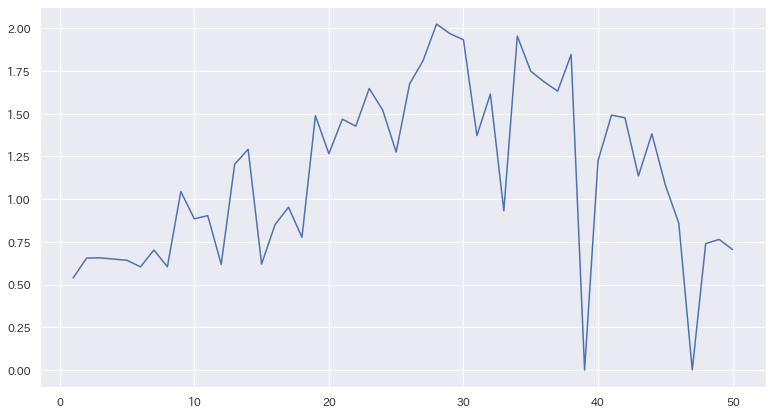

In [386]:
import numpy as np
import matplotlib.pyplot as plt
 
# 折れ線グラフを出力
x_plot = np.linspace(1, 50) 
y_plot = interpo_evi.iloc[0:1,1:-2].values.T
plt.plot(x_plot, y_plot)

In [387]:
type(interpo_evi)

pandas.core.frame.DataFrame

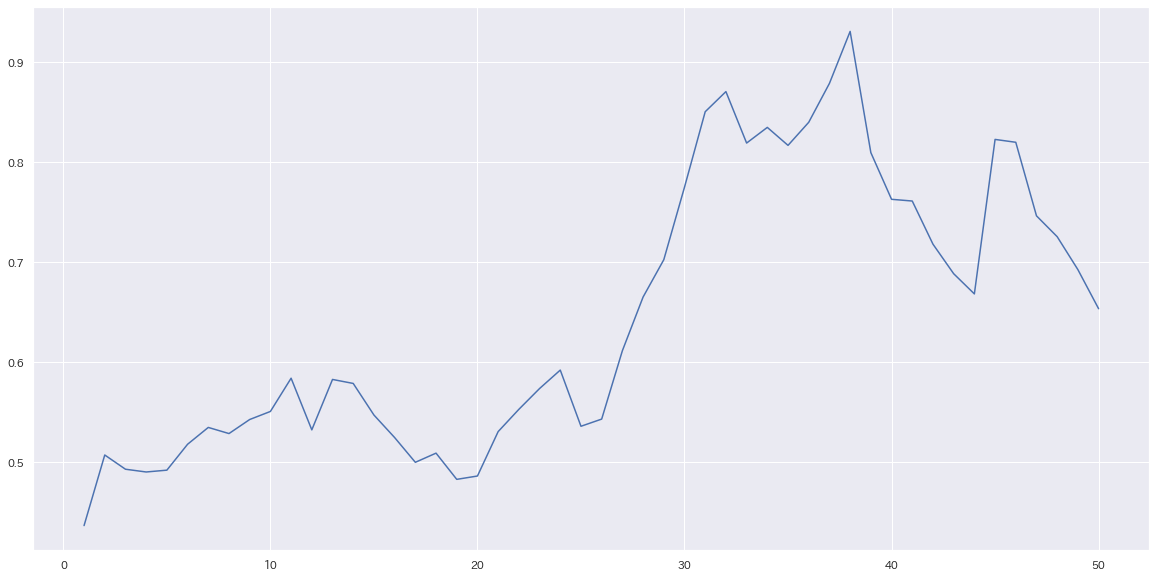

In [388]:
# 移動平均を取った場合を確認 rolling6　ぐらいにするとやっと下降するグラフは消える。　そもそも雲を消す方が優先。

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
rolled_evi = interpo_evi.copy()
 
# 折れ線グラフを出力
x_plot = np.linspace(1, 50) 
rolled_evi.iloc[:,1:-2] = rolled_evi.iloc[:,1:-2].rolling(6, min_periods=1, axis=1).mean()
y_plot = rolled_evi.iloc[1,1:-2].values.T
plt.plot(x_plot, y_plot)


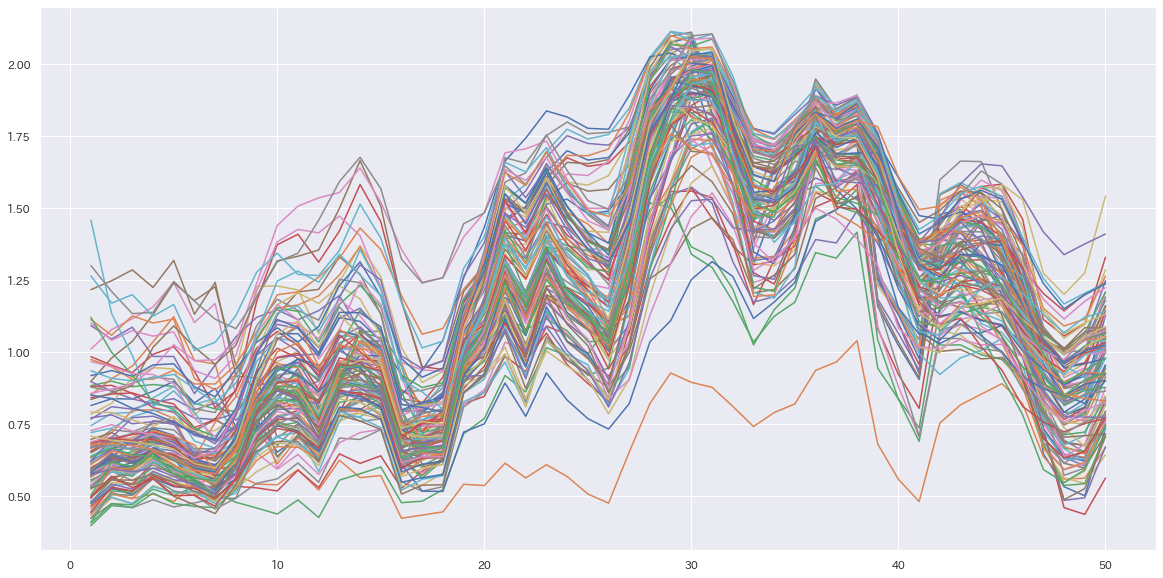

In [389]:
# 全圃場の表示
x_plot = np.linspace(1, 50) 
rolled_evi = interpo_evi.copy()
rolled_evi.iloc[:,1:-2] = interpo_evi.iloc[:,1:-2].rolling(3, min_periods=1, axis=1).mean()
y_plot = rolled_evi.iloc[1,1:-2].values.T

plt.figure(figsize=(20,10))

for i in range(rolled_evi.iloc[:,1:-2].shape[0]):
    y_plot = rolled_evi.iloc[i,1:-2].values.T
    plt.plot(x_plot, y_plot,label="圃場番号" + str(rolled_evi.iloc[i,0]))
    # plt.legend() # (3)凡例表示

    
plt.show()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


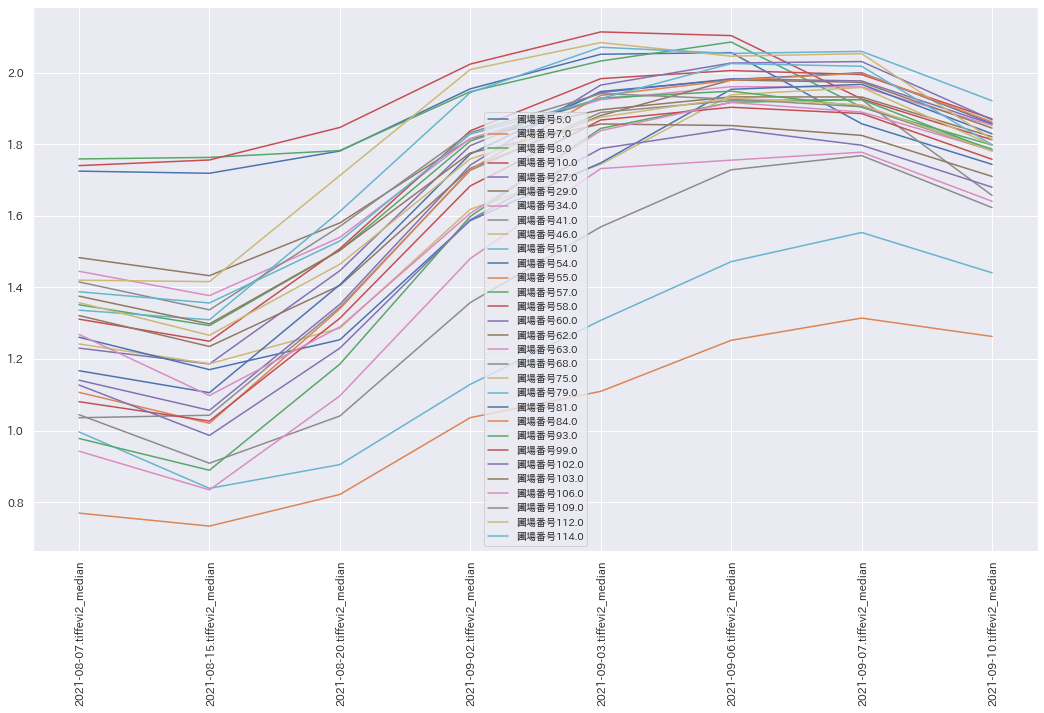

In [390]:
# 収量のあるデータだけで表示
interpo_evi_yield= interpo_evi.dropna()

#全期間見る時は.iloc[:,1:-2]　
slice_a = 25
slice_b = 33
x_plot = interpo_evi.iloc[:,slice_a:slice_b].columns
rolled_evi = interpo_evi.copy()

rolled_yield_evi.iloc[:,1:-2] = interpo_evi.iloc[:,1:-2].rolling(3, min_periods=1, axis=1).mean()

plt.figure(figsize=(18,10))
# 31圃場見ると見づらいのでRangeで数指定
for i in range(1,31):
    y_plot = rolled_yield_evi.iloc[i,slice_a:slice_b].values.T
    plt.plot(x_plot, y_plot,label="圃場番号" + str(rolled_yield_evi.iloc[i,0]))
    plt.legend(fontsize = 10) # (3)凡例表示
    plt.xticks(rotation=90)

plt.show()

一通りプロットした結果 　EVIの時系列変化と収量の考察  
* 今の時系列EVI全て与えても　場所によって雲でEVI値が降下してしまう場所もあるので危険  
* 時系列で全ての画像を利用する際には必ず雲のある地点はNull値として除外する処理が必須。
* 雲をNullで除外できていれば移動平均をしても以前の値より下がるようなことはないはず。　次回検証
* 収量との相関確認して、相関高いところだけ抽出して重回帰を行う。
    * できれば生育初期と末期の植生指数の推移も説明変数として入れたいが、雲の影響を評価しきれないので相関高いところだけで検討する

In [396]:
# rollingで移動平均を取る
rolled_evi = interpo_evi
rolled_evi.iloc[:,1:-2] = interpo_evi.iloc[:,1:-2].rolling(6, min_periods=1, axis=1).mean()

In [397]:
# 収量以外Nullなしのデータ完成
print(rolled_evi.isnull().sum())

圃場番号                           0
2021-06-25.tiffevi2_median     0
2021-06-27.tiffevi2_median     0
2021-06-28.tiffevi2_median     0
2021-06-29.tiffevi2_median     0
2021-06-30.tiffevi2_median     0
2021-07-01.tiffevi2_median     0
2021-07-02.tiffevi2_median     0
2021-07-07.tiffevi2_median     0
2021-07-14.tiffevi2_median     0
2021-07-15.tiffevi2_median     0
2021-07-16.tiffevi2_median     0
2021-07-17.tiffevi2_median     0
2021-07-18.tiffevi2_median     0
2021-07-20.tiffevi2_median     0
2021-07-21.tiffevi2_median     0
2021-07-24.tiffevi2_median     0
2021-07-25.tiffevi2_median     0
2021-07-26.tiffevi2_median     0
2021-07-30.tiffevi2_median     0
2021-07-31.tiffevi2_median     0
2021-08-02.tiffevi2_median     0
2021-08-03.tiffevi2_median     0
2021-08-05.tiffevi2_median     0
2021-08-06.tiffevi2_median     0
2021-08-07.tiffevi2_median     0
2021-08-15.tiffevi2_median     0
2021-08-20.tiffevi2_median     0
2021-09-02.tiffevi2_median     0
2021-09-03.tiffevi2_median     0
2021-09-06

## 2-2　収量予測

### 2-2-0 相関確認

In [398]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [399]:
rolled_evi_yield.columns

Index(['圃場番号', '2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffe

In [400]:
rolled_evi_yield_dropped = rolled_evi_yield[['2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
       '2021-09-07.tiffevi2_median', '2021-09-10.tiffevi2_median',
       '2021-09-12.tiffevi2_median', '2021-09-15.tiffevi2_median',
       '2021-09-19.tiffevi2_median', '2021-09-21.tiffevi2_median',
       '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
       '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
       '2021-10-03.tiffevi2_median', '2021-10-07.tiffevi2_median',
       '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
       '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
       '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
       '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',
       '15%反収現物重量kg/10a']]

In [401]:
corr = rolled_evi_yield_dropped.corr()

<AxesSubplot:>

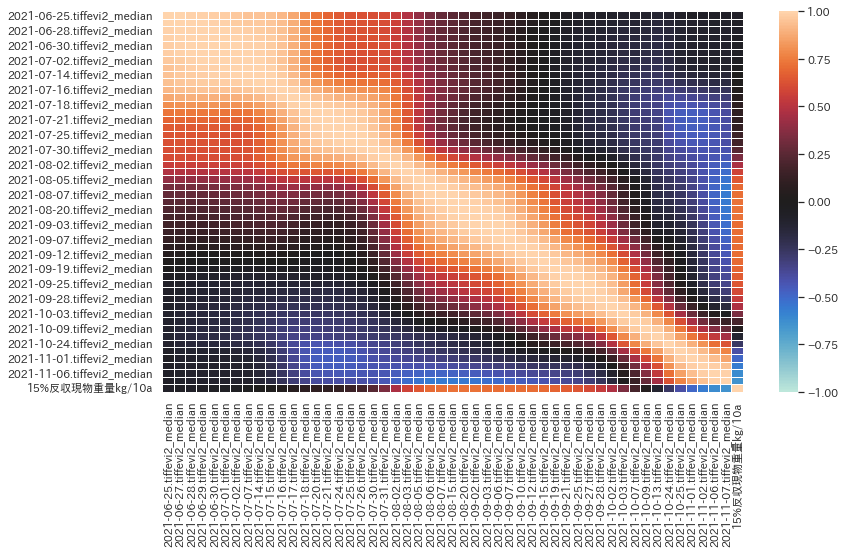

In [404]:
# sns　setするとフォントもデフォルトのsans serifになって文字化けするから、Plotサイズ変える時にフォントも指定する
sns.set(rc = {'figure.figsize':(13,7)},font='IPAexGothic')
sns.heatmap(corr, vmax=1, vmin=-1, center=0,linewidths=.5)

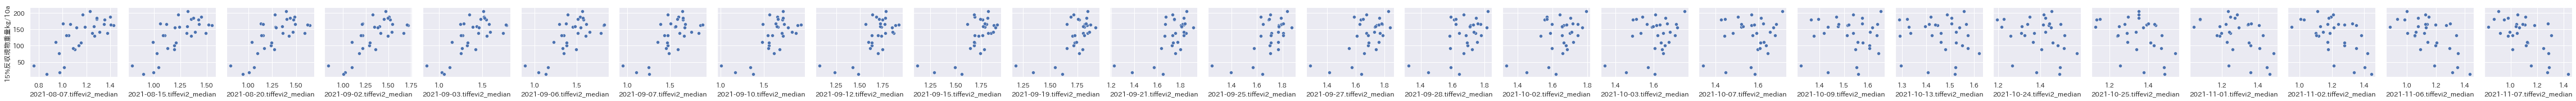

In [571]:
sns.pairplot(rolled_evi_yield_dropped, x_vars=[
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
        '2021-09-07.tiffevi2_median', '2021-09-10.tiffevi2_median',
       '2021-09-12.tiffevi2_median', '2021-09-15.tiffevi2_median',
       '2021-09-19.tiffevi2_median', '2021-09-21.tiffevi2_median',
       '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
       '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
       '2021-10-03.tiffevi2_median', '2021-10-07.tiffevi2_median',
       '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
       '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
       '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
       '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',],
             y_vars=['15%反収現物重量kg/10a'], palette='Blues')

9月初めのEVIは正の相関があって11月は初めの値は負の相関がある。　青ダチがある圃場の方が

### 2-2-1　学習　9月2日線形回帰の場合

In [458]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [459]:
rolled_evi_yield.iloc[:,28]


0      1.494418
4      1.671072
8      1.719156
10     1.702946
26     1.343149
28     1.543443
32     1.467822
37     1.099231
42     1.288873
47     1.026287
50     1.295267
51     0.839441
53     1.360933
54     1.417146
56     1.180593
58     1.400519
59     1.005157
63     1.215198
69     1.535668
72     1.382939
74     1.216399
77     1.217833
86     1.096993
91     1.198261
94     1.211894
95     1.509117
98     1.324963
101    1.521839
104    1.452656
106    1.493358
Name: 2021-09-02.tiffevi2_median, dtype: float64

In [460]:
# このXで全てのEVIではなく、9月28日のデータだけ取得
X = rolled_evi_yield.iloc[:,28]
Y = rolled_evi_yield.iloc[:,-2] 

In [463]:
X_linear = X.values.reshape(-1, 1)
Y_linear = Y.values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_linear,Y_linear)

b=reg.coef_
a=reg.intercept_

print("r={}".format(reg.score(X_linear, Y_linear)))

print("b={}".format(reg.coef_))
print("a={}".format(reg.intercept_))

r=0.5170688007859319
b=[[179.06826398]]
a=[-109.41257141]


Text(0, 0.5, 'Yield')

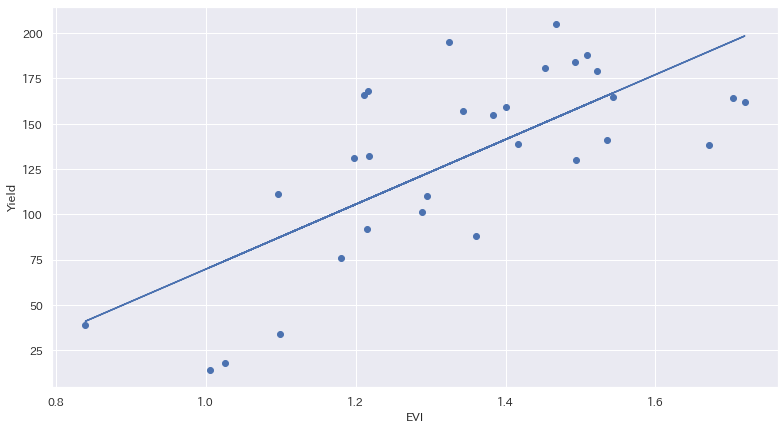

In [465]:
plt.plot(X_linear,b*X_linear+a)
plt.scatter(X_linear,Y_linear)
plt.xlabel('EVI')
plt.ylabel('Yield')

### 2-2-2　予測　 9月2日線形回帰から収量予測

In [446]:
pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
X = pred_evi_yield.iloc[:,28]
X_pred_yield = X.values.reshape(-1, 1)
pred_evi_yield['pred_yield'] = reg.predict(X_pred_yield)

/tmp/ipykernel_89262/3862731265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_evi_yield['pred_yield'] = reg.predict(X_pred_yield)


Text(0, 0.5, 'Yield')

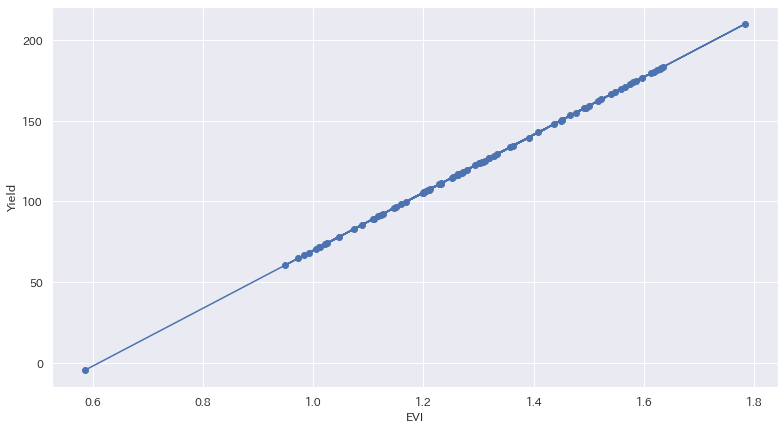

In [466]:
plt.plot(X_pred_yield,b*X_pred_yield+a)
plt.scatter(X_pred_yield,pred_evi_yield['pred_yield'])
plt.xlabel('EVI')
plt.ylabel('Yield')

In [545]:
pred_evi_yield.sort_values("pred_yield")

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-13.tiffevi2_median,2021-10-24.tiffevi2_median,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry,pred_yield
1,2.0,0.436166,0.471449,0.478470,0.481290,0.483348,0.489033,0.505388,0.508960,0.517242,...,0.734189,0.736386,0.745887,0.743420,0.744661,0.745339,0.742875,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",-4.404377
39,43.0,0.602090,0.617666,0.619679,0.622768,0.623606,0.620944,0.621095,0.617029,0.623274,...,1.388144,1.370061,1.370415,1.355382,1.332454,1.304174,1.265118,NaN,"POLYGON ((140.05985 40.29499, 140.05986 40.294...",60.626318
40,44.0,0.477530,0.506947,0.519107,0.527706,0.530645,0.530447,0.539363,0.538092,0.544868,...,1.457488,1.421385,1.402285,1.366754,1.318763,1.268582,1.209196,NaN,"POLYGON ((140.05930 40.29516, 140.05941 40.295...",64.757583
38,42.0,0.532233,0.561557,0.573963,0.581324,0.582805,0.579893,0.585512,0.583892,0.587541,...,1.503898,1.484628,1.477453,1.449922,1.407057,1.352243,1.281355,NaN,"POLYGON ((140.06095 40.29389, 140.06090 40.293...",66.788970
46,50.0,0.575809,0.597161,0.609264,0.626448,0.633969,0.634202,0.644795,0.656075,0.672542,...,1.370913,1.346329,1.335226,1.308961,1.279009,1.244316,1.197707,NaN,"POLYGON ((140.05996 40.29547, 140.06063 40.295...",68.355919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,116.0,0.670364,0.673312,0.670130,0.668268,0.665047,0.659714,0.652141,0.649723,0.663468,...,1.459090,1.329993,1.222585,1.123010,1.031768,0.954908,0.898076,NaN,"POLYGON ((140.08632 40.28684, 140.08700 40.287...",181.491157
12,12.0,0.851952,0.879749,0.903824,0.925319,0.947644,0.949993,0.974211,0.975571,0.960438,...,1.416680,1.390600,1.367738,1.319687,1.255188,1.178062,1.098980,NaN,"POLYGON ((140.02167 40.27618, 140.02341 40.276...",182.300761
11,11.0,0.814812,0.826608,0.830200,0.835606,0.843434,0.841286,0.850348,0.847344,0.840465,...,1.391696,1.356455,1.324202,1.268685,1.199887,1.120963,1.043503,NaN,"POLYGON ((140.02165 40.27590, 140.02339 40.275...",182.680885
67,73.0,0.856880,0.864792,0.872865,0.885377,0.901231,0.905991,0.923048,0.949385,0.985231,...,1.187076,1.123627,1.080385,1.035024,0.992924,0.960812,0.930793,NaN,"MULTIPOLYGON (((140.06683 40.28277, 140.06718 ...",183.253258


EVI値が異様に低い場所で終了がマイナスとなってしまっている。　この場所の値を異常値として落とすか？重回帰も行うか？  
重回帰してマイナスで出なかったら重回帰を採用

### 2-2-3　学習　重回帰の場合

#### 2-2-3-0 共通処理

In [407]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [502]:
# このXで全てのEVIではなく、8月7日から9月6日までのデータだけ取得
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

#### 2-2-3-1 Sklearnで全モデル比較

In [504]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from lightgbm import LGBMRegressor
import xgboost as xgb

reg_dict = {"LinearRegression": LinearRegression(),
            "xgboost": xgb.XGBRegressor(),
            "Lightgbm": LGBMRegressor(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
                    }

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_regression
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_size = 0.2  # 分割比率
N_trials = 5  # 試行回数

mape_dict = {reg_name:[] for reg_name in reg_dict.keys()}  # 精度の格納庫

for i in range(N_trials):
    print(f"Trial {i+1}")
    x_train, x_test, y_train, y_test = train_test_split(X_multi, Y.ravel(), test_size=test_size, random_state=42)

    for reg_name, reg in reg_dict.items():
        reg.fit(x_train,y_train)
        y_pred = reg.predict(x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPEを算出
        mape_dict[reg_name].append(mape)  # 格納

# MAPEの平均値でソート
mape_dict_sorted = {key: value for key, value in reversed(sorted(mape_dict.items(), key=lambda x:np.mean(x[1])))}

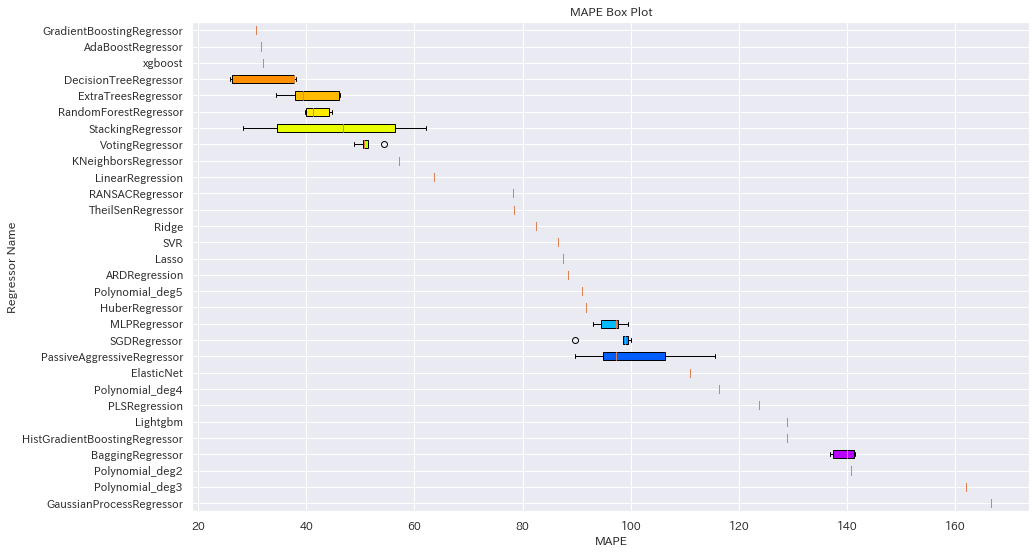

In [509]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.rcParams["font.size"] = 18  # フォントサイズを大きくする
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(mape_dict)), cmap=plt.get_cmap('gist_rainbow_r'))

plt.figure(figsize=(15,9))
box=plt.boxplot(mape_dict_sorted.values(), vert=False, patch_artist=True,labels=mape_dict_sorted.keys())
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(scalarMap.to_rgba(i))
plt.title("MAPE Box Plot")
plt.xlabel("MAPE")
plt.ylabel("Regressor Name")
plt.show()

#### 2-2-3-2 Sklearnでリッジ回帰ラッソ回帰勾配ブースティング比較

R-squared_Lasso :  0.011117879919743445
R-squared_Ridge :  0.11550831551649421
###################################################
{'fit_time': array([0.00251842, 0.00145316, 0.00106978, 0.00111461, 0.00119472]), 'score_time': array([0.01334834, 0.00070214, 0.0008018 , 0.00064373, 0.0007081 ]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.00097466, 0.00071025, 0.00073671, 0.00096893, 0.00079393]), 'score_time': array([0.00096297, 0.00068092, 0.0013113 , 0.00070763, 0.0007441 ]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.01302576, 0.00845623, 0.00825357, 0.00849295, 0.00907731]), 'score_time': array([0.00231004, 0.00105357, 0.00103235, 0.00116181, 0.00238848]), 'test_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1544, in precision_re

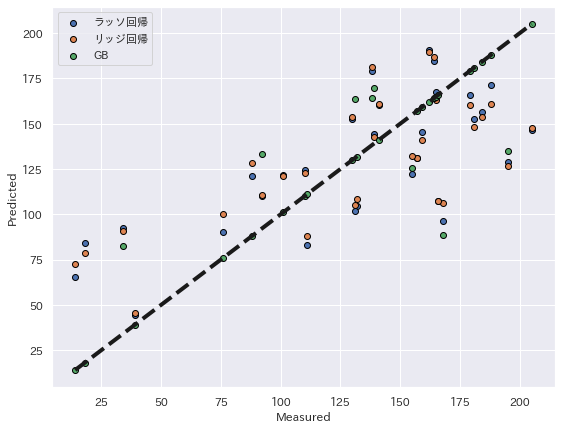

In [533]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def sklearn_calc(labels, params):
    # トレーニングデータとテストデータに分割
    x_train, x_test, y_train, y_test = train_test_split(
    params, labels.ravel(), test_size=0.25)

    # Lasso
    LassoModel = Lasso(alpha=1.0, random_state=0)
    LassoModel.fit(x_train, y_train)

    # Rideg
    RidgeModel = Ridge(alpha=1.0, random_state=0)
    RidgeModel.fit(x_train, y_train)

    # GB
    GBModel =GradientBoostingRegressor(random_state=0)
    GBModel.fit(x_train, y_train)


    scoring = {"p": "precision_macro",
            "r": "recall_macro",
            "f":"f1_macro"}

    # 各モデルによる回帰の評価(決定係数の表示)
    print("R-squared_Lasso : ", LassoModel.score(x_test, y_test))
    print("R-squared_Ridge : ", RidgeModel.score(x_test, y_test))
    # print("R-squared_LinReg : ", LinRegModel.score(x_test, y_test))

    # データセットをランダムに5分割するための変数cvを定義
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    print('###################################################')
    scores = cross_validate(LassoModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(RidgeModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(GBModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    # print("R-squared_Average_LinReg　: {0:.2f}".format(scores.mean()))

    # matplotでグラフ化
    min_label = labels.ravel().min()
    max_label = labels.ravel().max()
    Lasso_predicted = LassoModel.predict(params)
    Ridge_predicted = RidgeModel.predict(params)
    GBModel_predicted = GBModel.predict(params)

    fig, ax = plt.subplots(figsize=(9,7))
    ax.scatter(labels.ravel(), Lasso_predicted, edgecolors=(0, 0, 0),label='ラッソ回帰')
    ax.scatter(labels.ravel(), Ridge_predicted, edgecolors=(0, 0, 0),label='リッジ回帰')
    ax.scatter(labels.ravel(), GBModel_predicted, edgecolors=(0, 0, 0),label='GB')
    ax.plot([min_label, max_label],
            [min_label, max_label], 'k--', lw=4)
    ax.legend()
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    return
sklearn_calc(Y,X_multi)

#### 2-2-3-3 StatsModelsでラッソ回帰線形回帰の各値の評価

↓Statsmodelは線形回帰モデルの引数のL1_wtに"0"を与えたらRidge回帰"1"を与えたらLasso回帰
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html

In [486]:

# statsmodels　での方法重回帰分析について
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 植生指数は正規化済みなので標準化不要
# scaler = StandardScaler() # インスタンス
# scaler.fit(np.array(interpo_evi_yield)) # 標準化を適応
# df_std = scaler.transform(np.array(interpo_evi_yield)) # 標準化する
# df_std = pd.DataFrame(df_std, columns=interpo_evi_yield.columns) # データフレームに変換
x_pred = X_multi
y_pred = Y

X_con = sm.add_constant(x_pred)

model = sm.OLS(y_pred, X_con) # モデルを作成

# result = model.fit() # モデルを適応
# L1_wt = 1 なのでrasso回帰
result = model.fit_regularized(L1_wt=1, refit=True)
result.summary() # 結果を確認

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        15%反収現物重量kg/10a   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     6.409
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           0.000298
Time:                        12:05:48   Log-Likelihood:                -144.84
No. Observations:                  30   AIC:                             305.7
Df Residuals:                      23   BIC:                             316.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -246.5159     81.985     -3.007      0.006    -416.114     -76.918
2021-08-07.tiffevi2_median -1028.0267   1410.810     -0.729      0.474   -3946.509    1890.455
2021-08-15.tiffevi2_median   704.2319   3255.650      0.216      0.831   -6030.592    7439.056
2021-08-20.tiffevi2_median  -328.0287   4571.814     -0.072      0.943   -9785.546    9129.489
2021-09-02.tiffevi2_median  5236.0043   2972.410      1.762      0.091    -912.894    1.14e+04
2021-09-03.tiffevi2_median -7322.6777   2812.212     -2.604      0.016   -1.31e+04   -1505.173
2021-09-06.tiffevi2_median  2951.4977   1515.057      1.948      0.064    -182.637    6085.633
==============================================================================
Omnibus:                        0.458   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.582
Skew:                           0.100   Prob(JB):                        0.747
Kurtosis:                       2.347   Cond. No.                     3.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ラッソでモデルを適応するためにはfit_regularizedでL1_wt=1を使う必要があるが、このときrefit=Trueも必ず入れないとSummaryが表示されない。理由を考える。

雲の乗ったデータに関してはマイナスの相関が出るようになってしまっている？　雲のフィルタリング機能が必要  
9月2日のデータ以外P値が高い？　9月3日のデータはなぜマイナスの回帰係数なのか？


Statsmodelsの解釈の仕方について
https://dataanablog.com/statistical-methods-in-python-for-beginners-multiple-regression-analysis/

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

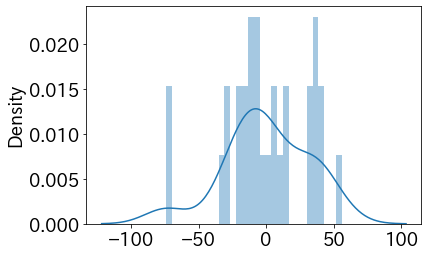

In [308]:
# 回帰分析は残差が正規分布になっていることが望ましいので、プロットして確認
sns.distplot(result.resid,bins=30)

### 2-2-4　予測　重回帰の場合

In [550]:
rolled_evi_yield= rolled_evi.dropna()
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

In [551]:
x_train, x_test, y_train, y_test = train_test_split(
X_multi, Y.ravel(), test_size=0.25)

# Lasso
LassoModel = Lasso(alpha=1.0, random_state=0)
LassoModel.fit(x_train, y_train)

# Rideg
RidgeModel = Ridge(alpha=1.0, random_state=0)
RidgeModel.fit(x_train, y_train)

# LinReg
LinRegModel = LinearRegression()
LinRegModel.fit(x_train, y_train)

# GBModel
GBModel =GradientBoostingRegressor(random_state=0)
GBModel.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [552]:
multi_pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
X_pred_multi = pred_evi_yield.iloc[:,25:31]

multi_pred_evi_yield['Lasso_pred_yield'] = LassoModel.predict(X_pred_multi)
multi_pred_evi_yield['Ridge_pred_yield'] = RidgeModel.predict(X_pred_multi)
multi_pred_evi_yield['GB_pred_yield'] = GBModel.predict(X_pred_multi)


/tmp/ipykernel_89262/2025974320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_pred_evi_yield['Lasso_pred_yield'] = LassoModel.predict(X_pred_multi)
/tmp/ipykernel_89262/2025974320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_pred_evi_yield['Ridge_pred_yield'] = RidgeModel.predict(X_pred_multi)
/tmp/ipykernel_89262/2025974320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [553]:
multi_pred_evi_yield

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry,Lasso_pred_yield,Ridge_pred_yield,GB_pred_yield
1,2.0,0.436166,0.471449,0.478470,0.481290,0.483348,0.489033,0.505388,0.508960,0.517242,...,0.745887,0.743420,0.744661,0.745339,0.742875,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",2.236712,7.085045,38.885586
2,3.0,0.883493,0.891488,0.887744,0.887449,0.887648,0.881626,0.875285,0.864969,0.860833,...,1.046357,1.018503,0.992646,0.968487,0.943517,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",93.541810,95.496625,109.282241
3,4.0,0.880429,0.882656,0.874078,0.861970,0.855334,0.844842,0.829125,0.808322,0.794469,...,1.330175,1.281007,1.217805,1.146328,1.073730,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",175.760032,172.811657,139.451928
5,6.1,1.217154,1.232582,1.250272,1.243406,1.252805,1.245433,1.248172,1.226515,1.182418,...,1.379257,1.324177,1.251152,1.162739,1.068621,NaN,"POLYGON ((140.02138 40.27369, 140.02286 40.273...",173.122107,168.306406,134.358269
6,6.2,1.010939,1.044686,1.068619,1.081596,1.100569,1.102102,1.127445,1.121767,1.095643,...,1.362505,1.312496,1.247103,1.167723,1.082998,NaN,"POLYGON ((140.02145 40.27400, 140.02285 40.273...",166.635175,161.183084,154.536192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,0.708381,0.701254,0.697157,0.694318,0.690565,0.683963,0.672225,0.669249,0.680947,...,1.242946,1.188112,1.145669,1.118206,1.104321,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287...",152.813635,152.304631,182.393822
110,118.0,0.935511,0.922234,0.914870,0.915502,0.915859,0.911023,0.899846,0.899649,0.910962,...,1.221896,1.189834,1.171546,1.164860,1.163452,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287...",123.398128,125.372271,139.465306
111,119.0,0.850936,0.845031,0.831745,0.824565,0.817702,0.808165,0.790110,0.780420,0.788847,...,1.384214,1.323536,1.264239,1.209597,1.162144,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287...",151.119959,150.922866,181.557133
112,120.0,0.679679,0.681486,0.679577,0.676399,0.672175,0.665587,0.655620,0.649891,0.658054,...,1.536857,1.471074,1.383859,1.287021,1.186355,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287...",170.454928,168.229549,144.648405


In [547]:
# 9月2日衛生画像の線形回帰の予測結果
pred_evi_yield['pred_yield']

1       -4.404377
2       92.263915
3      179.311575
5      176.518700
6      169.650731
          ...    
109    155.017323
110    123.873971
111    153.224163
112    173.694853
113    111.120289
Name: pred_yield, Length: 83, dtype: float64

In [554]:
# 単回帰の予測値と重回帰の予測値を結合して出力
multi_pred_evi_yield['linear_0902_pred_yield'] = pred_evi_yield['pred_yield']

/tmp/ipykernel_89262/1799612289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_pred_evi_yield['linear_0902_pred_yield'] = pred_evi_yield['pred_yield']


In [ ]:
rolled_evi_yield

In [566]:
# 元の収量のデータが入ったデータとも結合
concat_pd = pd.concat([rolled_evi_yield, multi_pred_evi_yield])

In [569]:
concat_pd.columns

Index(['圃場番号', '2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffe

In [581]:
# 不要なEVIを落とす　計算に利用したEVIのみ表示　8月7日から9月6日
concat_pred_evi_yield = concat_pd[['圃場番号', 
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
       '15%反収現物重量kg/10a', 'geometry', 'Lasso_pred_yield', 'Ridge_pred_yield',
       'GB_pred_yield', 'linear_0902_pred_yield']].copy()

In [582]:
concat_pred_evi_yield

,圃場番号,2021-08-07.tiffevi2_median,2021-08-15.tiffevi2_median,2021-08-20.tiffevi2_median,2021-09-02.tiffevi2_median,2021-09-03.tiffevi2_median,2021-09-06.tiffevi2_median,15%反収現物重量kg/10a,geometry,Lasso_pred_yield,Ridge_pred_yield,GB_pred_yield,linear_0902_pred_yield
0,1.0,1.267065,1.351999,1.422913,1.494418,1.555549,1.607466,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",NaN,NaN,NaN,NaN
4,5.0,1.374422,1.488161,1.586250,1.671072,1.742455,1.791612,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",NaN,NaN,NaN,NaN
8,8.0,1.426643,1.548194,1.643021,1.719156,1.780758,1.820570,162.0,"POLYGON ((140.02314 40.27434, 140.02316 40.274...",NaN,NaN,NaN,NaN
10,10.0,1.402527,1.516268,1.616605,1.702946,1.777416,1.831565,164.0,"POLYGON ((140.02158 40.27552, 140.02315 40.275...",NaN,NaN,NaN,NaN
26,27.0,1.186824,1.239084,1.286210,1.343149,1.389279,1.453340,157.0,"POLYGON ((140.06002 40.28557, 140.06006 40.285...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,1.305627,1.378916,1.428184,1.476699,1.505469,1.546381,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287...",152.813635,152.304631,182.393822,155.017323
110,118.0,1.180394,1.225282,1.259529,1.302780,1.334956,1.386186,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287...",123.398128,125.372271,139.465306,123.873971
111,119.0,1.305647,1.373583,1.420115,1.466685,1.493728,1.533601,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287...",151.119959,150.922866,181.557133,153.224163
112,120.0,1.375648,1.464412,1.527596,1.581003,1.611127,1.643738,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287...",170.454928,168.229549,144.648405,173.694853


In [583]:
# gpd で出力
concat_pred_evi_yield = gpd.GeoDataFrame(concat_pred_evi_yield, geometry='geometry')
concat_pred_evi_yield.to_file('/workspaces/akita_daizu/data/収量予測_120圃場.geojson', driver="GeoJSON")  

### 2-2-5　予測　Oputuna LGBM

In [534]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [535]:
# このXで全てのEVIではなく、8月7日から9月6日までのデータだけ取得
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

In [538]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import optuna

In [ ]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_multi, Y, test_size=0.25, random_state = 42)
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Best trial: {'lambda_l1': 3.117668913553932e-07, 'lambda_l2': 9.38502819112676, 'num_leaves': 95, 'feature_fraction': 0.8088697228912456, 'bagging_fraction': 0.5175916730604163, 'bagging_freq': 4, 'min_child_samples': 50}

In [543]:
import matplotlib.pyplot as plt
X_train, X_valid, y_train, y_valid = train_test_split(X_multi, Y, test_size=0.3,shuffle=True, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

evals_result = {} 
params = {
    'lambda_l1': 3.117668913553932e-07, 'lambda_l2': 9.38502819112676, 'num_leaves': 95, 'feature_fraction': 0.8088697228912456, 'bagging_fraction': 0.5175916730604163, 'bagging_freq': 4, 'min_child_samples': 50
    ,'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=500000,
    early_stopping_rounds=10,
    evals_result = evals_result
)

multi_pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
X_pred_multi = pred_evi_yield.iloc[:,25:31]

y_pred = model.predict(X_pred_multi, num_iteration=model.best_iteration)

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 21, number of negative: 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 21, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re